In [2]:
# Turn americangut into a binary classification problem


In [3]:
import anndata
import numpy as np


In [4]:
adata = anndata.read_h5ad("data/americangut_embeddings.h5ad")


In [5]:
def report(column, normalize=False):
    """Report on column values. Call this for manual inspection"""
    print(adata.obs[column].str.lower().value_counts(normalize=normalize))


report("ibd")


ibd
i do not have this condition                                         26122
nan                                                                   5137
diagnosed by a medical professional (doctor, physician assistant)     1089
self-diagnosed                                                         219
diagnosed by an alternative medicine practitioner                       37
not provided                                                             3
unspecified                                                              1
Name: count, dtype: int64


In [16]:
# Use this to build up a master list

for col in adata.obs.columns[50:60]:
    print(adata.obs.dtypes[col])
    if adata.obs.dtypes[col] == "category":
        report(col)

neg_master = ["no", "false", "i do not have this condition", "never"]

pos_master = [
    "yes",
    "true",
    "diagnosed by a medical professional (doctor, physician assistant)",
    "self-diagnosed",
    "diagnosed by an alternative medicine practitioner",
    "rarely (less than once/week)",
    "rarely (a few times/month)",
    "occasionally (1-2 times/week)",
    "regularly (3-5 times/week)",
    "daily",
]

nan_master = ["nan", "not provided", "not sure", "not collected", "unspecified"]


category
cancer_treatment
nan                  31048
surgery only           847
chemotherapy           260
not provided           188
radiation therapy      173
no treatment            87
unspecified              5
Name: count, dtype: int64
category
cardiovascular_disease
i do not have this condition                                         22371
nan                                                                   9158
diagnosed by a medical professional (doctor, physician assistant)     1041
self-diagnosed                                                          30
diagnosed by an alternative medicine practitioner                        6
not provided                                                             2
Name: count, dtype: int64
category
cat
no              21186
yes              7243
nan              4171
false               6
not provided        1
true                1
Name: count, dtype: int64
category
cdiff
i do not have this condition                                     

In [17]:
def classify(
    column,
    pos_vals=pos_master,
    neg_vals=neg_master,
    nan_vals=nan_master,
    data=adata.X.toarray(),
    balance=False,
    seed=None,
):
    vals = adata.obs[column].str.lower()
    nan_vals = vals.isna() | vals.isin(nan_vals)
    pos_vals = vals.isin(pos_vals)
    neg_vals = vals.isin(neg_vals)
    assert not (pos_vals & neg_vals).any()
    try:
        assert (pos_vals | neg_vals | nan_vals).all()
    except AssertionError:
        print(column)
        print(vals[~(pos_vals | neg_vals | nan_vals)])

    X = np.array(data)[~nan_vals]
    y = np.array(pos_vals)[~nan_vals]

    n_pos = y.sum()
    n_neg = (~y).sum()

    if balance:
        if seed is not None:
            np.random.seed(seed)
        # Balance the classes
        if n_pos > n_neg:
            drop = np.random.choice(
                np.where(y)[0], n_pos - n_neg, replace=False
            )
        elif n_neg > n_pos:
            drop = np.random.choice(
                np.where(~y)[0], n_neg - n_pos, replace=False
            )
        X = np.delete(X, drop, axis=0)
        y = np.delete(y, drop, axis=0)

    return X, y


In [8]:
X_ibd, y_ibd = classify(column="ibd", balance=True)


In [ ]:
# Basic experiment: XGBoost in different embeddings
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import pandas as pd

X_np = adata.X.toarray()

NDIM = 64

results = []
for column in ["ibd", "asd", "vivid_dreams"]:
    for embedding in [
        f"hyp_mix_{NDIM}", f"poi_mix_{NDIM}", f"euc_mix_{NDIM}", f"pca_{NDIM}"
    ]:
        X, y = classify(
            column=column, data=adata.obsm[embedding], balance=True, seed=42
        )
        xgb = XGBClassifier()
        score = cross_val_score(xgb, X, y, cv=5)
        print(f"{column} ({len(X)})\t{embedding}\t{score.mean():.4f} ± {score.std():.4f}")
        results.append(
            {
                "column": column,
                "embedding": embedding,
                "score": score.mean(),
                "score_std": score.std(),
            }
        )
        print()

results = pd.DataFrame(results)

ibd (2690)	hyp_mix_64	0.5985 ± 0.0712

ibd (2690)	poi_mix_64	0.5985 ± 0.0712

ibd (2690)	euc_mix_64	0.5844 ± 0.0689

ibd (2690)	pca_64	0.5844 ± 0.0637

asd (1512)	hyp_mix_64	0.5701 ± 0.0205

asd (1512)	poi_mix_64	0.5701 ± 0.0205

asd (1512)	euc_mix_64	0.5754 ± 0.0487

asd (1512)	pca_64	0.5701 ± 0.0305

vivid_dreams (15308)	hyp_mix_64	0.5105 ± 0.0094

vivid_dreams (15308)	poi_mix_64	0.5105 ± 0.0094

vivid_dreams (15308)	euc_mix_64	0.5131 ± 0.0035

vivid_dreams (15308)	pca_64	0.5063 ± 0.0115



([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'ibd hyp_mix_64'),
  Text(1, 0, 'ibd poi_mix_64'),
  Text(2, 0, 'ibd euc_mix_64'),
  Text(3, 0, 'ibd pca_64'),
  Text(4, 0, 'asd hyp_mix_64'),
  Text(5, 0, 'asd poi_mix_64'),
  Text(6, 0, 'asd euc_mix_64'),
  Text(7, 0, 'asd pca_64'),
  Text(8, 0, 'vivid_dreams hyp_mix_64'),
  Text(9, 0, 'vivid_dreams poi_mix_64'),
  Text(10, 0, 'vivid_dreams euc_mix_64'),
  Text(11, 0, 'vivid_dreams pca_64')])

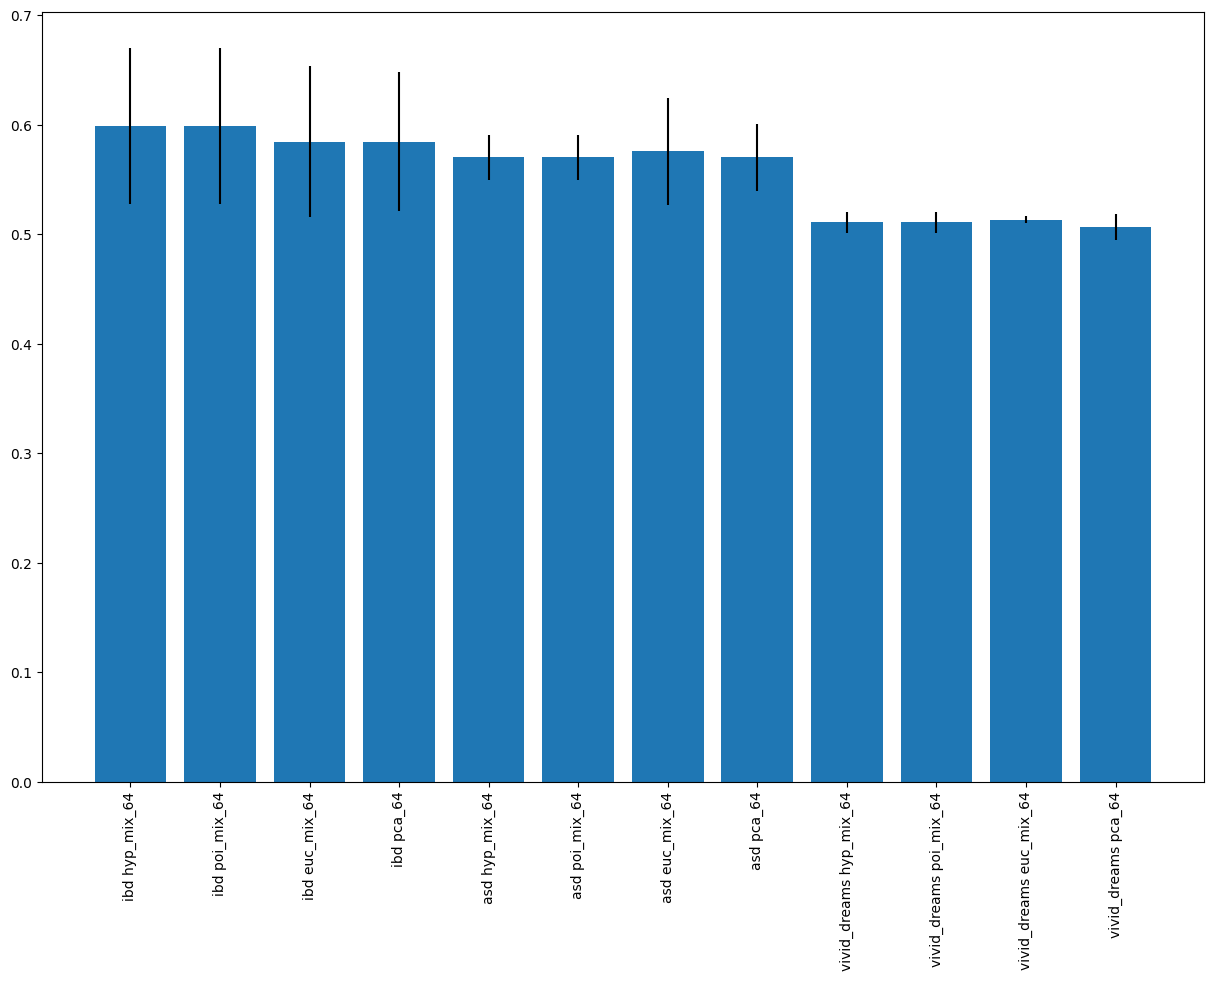

In [28]:
# Make a bar plot

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 10))
plt.bar(
    results["column"] + " " + results["embedding"],
    results["score"],
    yerr=results["score_std"],
)
plt.xticks(rotation=90)